# Classification & Localization of Objects in Images
---

## Project Overview
introduction and problem statement

## Data Exploration
familiarize yourself with the data, helps you to better understand and justify your results

statistics, visualizations

### Dataset structure

<pre>
+-- dataset\tiny-imagenet-200
    |--- wnids.txt
    |--- words.txt
    |+-- test
         |+-- images (10,000 files)
              |--- test_0.JPEG
              |--- ...
              |--- test_9999.JPEG
    |+-- train (200 directories)
         |+-- n01443537
              |+-- images (500 files)
                   |--- n01443537_0.JPEG
                   |--- ...
                   |--- n01443537_499.JPEG
              |--- n01443537_boxes.txt
         |+-- ...
         |+-- n12267677
    |+-- val
        |--- val_annotations.txt
        |+-- images (10,000 files)
             |--- val_0.JPEG
             |--- ...
             |--- val_9999.JPEG
</pre>

In [1]:
import os

DS_PATH = os.path.join ('..', 'datasets', 'tiny-imagenet-200')
DS_TRAIN_PATH = os.path.join (DS_PATH, 'train')
DS_VAL_PATH = os.path.join (DS_PATH, 'val')
DS_TEST_PATH = os.path.join (DS_PATH, 'test')

### Example image

              image  box_x1  box_y1  box_x2  box_y2
0  n01443537_0.JPEG       0      10      63      58


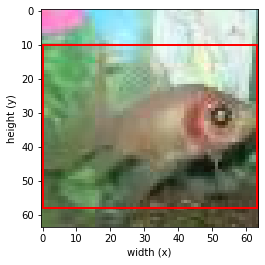

In [2]:
# check out the properties of the images (only one picture)
# display an image
# annotations of train images
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

DS_TRAIN_IMAGE = os.path.join (DS_TRAIN_PATH, 'n01443537', 'images', 'n01443537_0.JPEG')
train_img = io.imread (DS_TRAIN_IMAGE)

DS_TRAIN_IMAGE_ANNOT = os.path.join (DS_TRAIN_PATH, 'n01443537', 'n01443537_boxes.txt')
img_annot_df = pd.read_csv (DS_TRAIN_IMAGE_ANNOT, sep='\t', header=None, names=['image', 'box_x1', 'box_y1', 'box_x2', 'box_y2'])
print (img_annot_df.head (1))

fig, axs = plt.subplots (1, 1)
axs.set_ylabel ('height (y)')
axs.set_xlabel ('width (x)')
axs.imshow (train_img)
rect = patches.Rectangle ((img_annot_df.iloc[0][1],img_annot_df.iloc[0][2]),
                          (img_annot_df.iloc[0][3] - img_annot_df.iloc[0][1]),
                          (img_annot_df.iloc[0][4] - img_annot_df.iloc[0][2]),
                          linewidth=2,edgecolor='r',facecolor='none')
axs.add_patch (rect)
plt.show ()

### wnid file (wnids.txt)
holds all WordNet IDs of the dataset 

In [3]:
# check out the wnid annotations
import numpy as np
import pandas as pd

WNID_FILE = os.path.join (DS_PATH, 'wnids.txt')
wnid_df = pd.read_csv (WNID_FILE, header=None, names=['wnid'])

print (wnid_df.info ())
print (wnid_df.describe ())
print (wnid_df.sample (3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
wnid    200 non-null object
dtypes: object(1)
memory usage: 1.7+ KB
None
             wnid
count         200
unique        200
top     n02802426
freq            1
          wnid
120  n02403003
28   n07614500
147  n02814533


### words file (words.txt)
holds all WordNet IDs and their description(s)

In [4]:
import numpy as np
import pandas as pd

WNID_WORDS_FILE = os.path.join (DS_PATH, 'words.txt')
wnid_words_df = pd.read_csv (WNID_WORDS_FILE, sep='\t', header=None, names=['wnid', 'desc'])

print (wnid_words_df.info ())
print (wnid_words_df.describe ())
print (wnid_words_df.sample (3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82115 entries, 0 to 82114
Data columns (total 2 columns):
wnid    82115 non-null object
desc    82114 non-null object
dtypes: object(2)
memory usage: 1.3+ MB
None
             wnid   desc
count       82115  82114
unique      82115  76002
top     n07700003   head
freq            1     16
            wnid                            desc
69617  n13020011  Volvariella, genus Volvariella
81015  n15101157                brand, firebrand
14598  n02737351                             ark


In [5]:
# get the description of a wnid
#wnid = wnid_df['wnid'].sample ().values[0]
wnid = 'n01443537'
wnid_desc = wnid_words_df[wnid_words_df['wnid'] == wnid]['desc'].values[0]

print (wnid, wnid_desc)

n01443537 goldfish, Carassius auratus


## Benchmark
some other algorithm / software / result to compare this algorithm against (by using the defined metric)

In [7]:
# classification: random guess
# localization: - tbd (for example the mean of all contestors of this Kaggle competition)

---

In [8]:
# split project here into
# - multiclass classification
# - regression for localization

## Task: Classification

### Metric
used metric for classification is categorial cross-entropy

### Data Preprocessing

__train data__
<pre>
+-- dataset\tiny-imagenet-200
    |+-- train (200 directories)
         |+-- n01443537
              |+-- images (500 files)
                   |--- n01443537_0.JPEG
                   |--- ...
                   |--- n01443537_499.JPEG
              |--- n01443537_boxes.txt
         |+-- ...
         |+-- n12267677
</pre>

In [9]:
# read in all images from training dataset
from collections import defaultdict

# get a list of all image class directories
train_data = defaultdict (list)
train_path_entries = os.listdir (DS_TRAIN_PATH)
for i in range (len (train_path_entries)):
    entry_i_imgs_p = DS_TRAIN_PATH + os.sep + train_path_entries[i] + os.sep + 'images'
    
    # add data as key-value pair for later use
    k = train_path_entries[i]
    v = [entry_i_imgs_p + os.sep + img for img in os.listdir (entry_i_imgs_p)]
    train_data[k] = v

print ('Now there are {} keys (classes) in the dictionary, each holding {} values (image paths).'\
       .format (len (train_data.keys ()), len (train_data[list (train_data.keys ())[0]])))
print ()
print ('Example:',\
       'key (class) =', list (train_data.keys ())[42],\
       ', values (image paths) =',\
       train_data[list (train_data.keys())[42]][:2], '...',\
       train_data[list (train_data.keys())[42]][-2:])

Now there are 200 keys (classes) in the dictionary, each holding 500 values (image paths).

Example: key (class) = n02236044 , values (image paths) = ['../datasets/tiny-imagenet-200/train/n02236044/images/n02236044_0.JPEG', '../datasets/tiny-imagenet-200/train/n02236044/images/n02236044_1.JPEG'] ... ['../datasets/tiny-imagenet-200/train/n02236044/images/n02236044_98.JPEG', '../datasets/tiny-imagenet-200/train/n02236044/images/n02236044_99.JPEG']


CNN expects tensors in form (#, w, h, d) > read in images and create tensor per class.

[!] mixed BW and RGB images

In [10]:
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb

def image_path_to_tensor (img_path_list):
    img_list = []
    for img_path in img_path_list:
        img_arr = imread (img_path)
        # check depth for BW image
        if (len (img_arr.shape) < 3):
            img_arr = gray2rgb (img_arr)
        
        img_arr = np.expand_dims (img_arr, axis=0)
        img_list.append (img_arr)
    
    return np.vstack (img_list)
    
# unit test
# (image_path_to_tensor (train_data[list (train_data.keys())[42]][:5])).shape

In [11]:
train_data_tensor_list = []
train_data_targets_list = []
i = 1
for img_class, img_paths in train_data.items ():
    #pass
    # read images
    print ('\rReading images of wnid class {}, ({:4} / {:4})'.format (img_class, i, len (train_data.keys ())), end='', flush=True)
    img_class_tensor = image_path_to_tensor (train_data[img_class])
    # add images to train data tensor
    train_data_tensor_list.append (img_class_tensor)
    # write image class to target variable
    train_data_targets_list.append ([img_class for x in range (len (train_data[img_class]))])
    # blub
    i += 1

train_data_tensor = (np.vstack (train_data_tensor_list)).astype (dtype='f4', copy=False) / 255 # incl. normalization [0, 255] -> [0, 1]
train_data_targets = np.hstack (train_data_targets_list)

# clean up
del train_data_tensor_list
del train_data_targets_list
del train_data

print ('\n')
print ('Shape of train data tensor:', train_data_tensor.shape)
print ('Shape of train data target vector:', train_data_targets.shape)

Reading images of wnid class n01629819, (   2 /  200)

KeyboardInterrupt: 

__validation data__
<pre>
+-- dataset\tiny-imagenet-200
    |+-- val
        |--- val_annotations.txt
        |+-- images (10,000 files)
             |--- val_0.JPEG
             |--- ...
             |--- val_9999.JPEG
</pre>

In [12]:
from collections import defaultdict
import pandas as pd

# get a list of all image class directories
val_data = defaultdict (list)
entry_i_imgs_p = DS_VAL_PATH + os.sep + 'images'
k = 'val_imgs'
v = [entry_i_imgs_p + os.sep + img for img in os.listdir (entry_i_imgs_p)]
val_data[k] = v

# image annotations (contain wnid class)
DS_VAL_PATH_ANNOTS = DS_VAL_PATH + os.sep + 'val_annotations.txt'
val_annots_df = pd.read_csv (DS_VAL_PATH_ANNOTS, sep='\t', header=None, names=['image', 'wnid', 'box_x1', 'box_y1', 'box_x2', 'box_y2'])


print ('Now there are {} values (image paths) in validation set.'\
       .format (len (val_data['val_imgs'])))
print ()
print ('Example:',\
       'key =', list (val_data.keys ())[0],\
       ', values (image paths) =',\
       val_data[list (val_data.keys())[0]][:2], '...',\
       val_data[list (val_data.keys())[0]][-2:])

Now there are 10000 values (image paths) in validation set.

Example: key = val_imgs , values (image paths) = ['../datasets/tiny-imagenet-200/val/images/val_0.JPEG', '../datasets/tiny-imagenet-200/val/images/val_1.JPEG'] ... ['../datasets/tiny-imagenet-200/val/images/val_9998.JPEG', '../datasets/tiny-imagenet-200/val/images/val_9999.JPEG']


In [13]:
# read in all images from validation dataset
val_data_tensor_list = []
val_data_targets_list = []
i = 1
for img_path in val_data['val_imgs']:
    # read images
    print ('\rReading validation images, ({:5} / {:5})'.format (i, len (val_data['val_imgs'])), end='', flush=True)
    img_class_tensor = image_path_to_tensor ([img_path])
    # add images to  tensor
    val_data_tensor_list.append (img_class_tensor)
    # write image class to target variable
    img_name = os.path.basename (img_path)
    img_wnid = val_annots_df[val_annots_df['image'] == img_name]['wnid'].values[0]
    val_data_targets_list.append (img_wnid)
    # blub
    i += 1

val_data_tensor = (np.vstack (val_data_tensor_list)).astype (dtype='f4', copy=False) / 255 # incl. normalization [0, 255] -> [0, 1]
val_data_targets = np.hstack (val_data_targets_list)

# clean up
del val_data_tensor_list
del val_data_targets_list
del val_data

print ('\n')
print ('Shape of val data tensor:', val_data_tensor.shape)
print ('Shape of val data target vector:', val_data_targets.shape)

Reading validation images, (  124 / 10000)

KeyboardInterrupt: 

In [14]:
# one-hot encode targets
import pandas as pd

train_data_targets_onehot = pd.get_dummies (train_data_targets)

val_data_targets_onehot = pd.DataFrame (
    data= np.zeros ((val_data_targets.shape[0], train_data_targets_onehot.shape[1]),  dtype=train_data_targets_onehot.values.dtype),
    columns=train_data_targets_onehot.columns.values)

for i in range (val_data_targets.shape[0]):
    cur_wnid = val_data_targets[i]
    val_data_targets_onehot.iloc[i][cur_wnid] = 1

NameError: name 'train_data_targets' is not defined

In [14]:
# make arrays of everything (i.e. get rid of index and column)
train_targets = train_data_targets_onehot.values
val_targets = val_data_targets_onehot.values

# save the columns once to identify the wnid later
targets_names = train_data_targets_onehot.columns.values

In [15]:
print ('train data:')
print ('  ', 'type :', type (train_data_tensor))
print ('  ', 'dtype:', train_data_tensor.dtype)
print ('  ', 'shape:', train_data_tensor.shape)

print ()

print ('validation data:')
print ('  ', 'type :', type (val_data_tensor))
print ('  ', 'dtype:', val_data_tensor.dtype)
print ('  ', 'shape:', val_data_tensor.shape)

print ()

print ('target data:')
print ('  ', 'type :', type (train_targets))
print ('  ', 'dtype:', train_targets.dtype)
print ('  ', 'shape:', train_targets.shape)
print ('  ', 'names:', targets_names[:3], '...', targets_names[-3:])

train data:
   type : <class 'numpy.ndarray'>
   dtype: float32
   shape: (100000, 64, 64, 3)

validation data:
   type : <class 'numpy.ndarray'>
   dtype: float32
   shape: (10000, 64, 64, 3)

target data:
   type : <class 'numpy.ndarray'>
   dtype: uint8
   shape: (100000, 200)
   names: ['n01443537' 'n01629819' 'n01641577'] ... ['n09332890' 'n09428293' 'n12267677']


In [16]:
# shuffle data
RND_STATE = 42
from sklearn.model_selection import train_test_split

train_data_shuffled, _, train_targets_shuffled, _ = train_test_split (train_data_tensor, train_targets,
                                                                test_size=0.0, random_state=RND_STATE, shuffle=True)

val_data_shuffled, _, val_targets_shuffled, _ = train_test_split (val_data_tensor, val_targets,
                                                                  test_size=0.0, random_state=RND_STATE, shuffle=True)

In [17]:
# clean up
del train_data_tensor
del train_targets
del val_data_tensor
del val_targets

### Implementation

In [7]:
from keras import layers, models, optimizers

# basis: VGG16 model (https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md)

# input layer
input_shape = train_data_shuffled.shape[1:]
inputs = layers.Input (shape=input_shape, name='input')

# hidden layer
net = layers.Dense (
    units = 512,
    activation = 'relu',
    name = 'fc1'
) (inputs)

net = layers.Dense (
    units = 256,
    activation = 'relu',
    name = 'fc2'
) (net)

net = layers.Dense (
    units = 128,
    activation = 'relu',
    name = 'fc3'
) (net)

# output layer
outputs = layers.Dense (
    units=1,
    activation='linear',
    name='output'
) (net)

# create optimizer
opt_sgd = optimizers.SGD (lr=0.001)

# build and compile model
clf = models.Model (inputs=inputs, outputs=outputs)
clf.compile (optimizer=opt_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
clf.summary ()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1, 1, 1)           0         
_________________________________________________________________
fc1 (Dense)                  (None, 1, 1, 512)         1024      
_________________________________________________________________
fc2 (Dense)                  (None, 1, 1, 256)         131328    
_________________________________________________________________
fc3 (Dense)                  (None, 1, 1, 128)         32896     
_________________________________________________________________
output (Dense)               (None, 1, 1, 1)           129       
Total params: 165,377
Trainable params: 165,377
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.callbacks import ModelCheckpoint

epochs = 20

### Do NOT modify the code below this line.
checkpointer = ModelCheckpoint (
                    filepath='project.ml.imloc.weights.best.hdf5', 
                    verbose=1,
                    save_best_only=True)

history = clf.fit (train_data_shuffled, train_targets_shuffled,
          validation_data=(val_data_shuffled, val_targets_shuffled),
          epochs=epochs, batch_size=100, callbacks=[checkpointer], verbose=1)

Train on 100000 samples, validate on 10000 samples
Epoch 1/20
100000/100000 [==============================] - 1892s 19ms/step - loss: 5.2981 - acc: 0.0050 - val_loss: 5.2976 - val_acc: 0.0047

Epoch 00001: val_loss improved from inf to 5.29759, saving model to project.ml.imloc.weights.best.hdf5
Epoch 2/20
100000/100000 [==============================] - 1886s 19ms/step - loss: 5.2974 - acc: 0.0050 - val_loss: 5.2968 - val_acc: 0.0041

Epoch 00002: val_loss improved from 5.29759 to 5.29680, saving model to project.ml.imloc.weights.best.hdf5
Epoch 3/20
100000/100000 [==============================] - 1888s 19ms/step - loss: 5.2964 - acc: 0.0057 - val_loss: 5.2955 - val_acc: 0.0075

Epoch 00003: val_loss improved from 5.29680 to 5.29551, saving model to project.ml.imloc.weights.best.hdf5
Epoch 4/20
100000/100000 [==============================] - 1889s 19ms/step - loss: 5.2945 - acc: 0.0092 - val_loss: 5.2926 - val_acc: 0.0100

Epoch 00004: val_loss improved from 5.29551 to 5.29264, savi

KeyboardInterrupt: 

---

## Metric
define the metric to measure the quality of the learning algorithm

## Data Preprocessing

## Implementation
split data, define and train a model

---

## Model Evaluation and Validation
results and justification

---

## Helper stuff

In [ ]:
# list dataset directory with number of folders and files
import os

In [ ]:
ds_path = os.path.join ('dataset', 'tiny-imagenet-200')

print ('+--', ds_path)
path_entries = os.listdir (ds_path)
num_dirs = 0
num_files = 0
for entry in path_entries:
    entry_path = os.path.join (ds_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_test_path = os.path.join (ds_path, 'test')

print ('+--', ds_test_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_test_path)
for entry in path_entries:
    entry_path = os.path.join (ds_test_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_test_images_path = os.path.join (ds_test_path, 'images')

print ('+--', ds_test_images_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_test_images_path)
for entry in path_entries:
    entry_path = os.path.join (ds_test_images_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_val_path = os.path.join (ds_path, 'val')

print ('+--', ds_val_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_val_path)
for entry in path_entries:
    entry_path = os.path.join (ds_val_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_val_images_path = os.path.join (ds_val_path, 'images')

print ('+--', ds_val_images_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_val_images_path)
for entry in path_entries:
    entry_path = os.path.join (ds_val_images_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_train_path = os.path.join (ds_path, 'train')

print ('+--', ds_train_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_train_path)
for entry in path_entries:
    entry_path = os.path.join (ds_train_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_train_wnid_path = os.path.join (ds_train_path, 'n01443537')

print ('+--', ds_train_wnid_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_train_wnid_path)
for entry in path_entries:
    entry_path = os.path.join (ds_train_wnid_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
ds_train_wnid_images_path = os.path.join (ds_train_wnid_path, 'images')

print ('+--', ds_train_wnid_images_path)
num_dirs = 0
num_files = 0
path_entries = os.listdir (ds_train_wnid_images_path)
for entry in path_entries:
    entry_path = os.path.join (ds_train_wnid_images_path, entry)
    if (os.path.isdir (entry_path)):
        print ('    |+--', entry)
        num_dirs+=1
    if (os.path.isfile (entry_path)):
        print ('    |---', entry)
        num_files+=1
print ('directories:', num_dirs, ', files:', num_files)

In [ ]:
print ('directories:', num_dirs, ', files:', num_files)